# ⚡Swiggy - Complaint Classification using Neural Networks and NLP 

In [1]:
# import libraries
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
from nltk import PorterStemmer
from nltk import WordNetLemmatizer
from nltk.corpus import stopwords
from string import punctuation
nltk.download('stopwords')
nltk.download('wordnet')



[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\junaid\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\junaid\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [2]:
# load dataset

df=pd.read_csv(r'D:\GRADIOUS\PROJECT\DL & NLP Swiggy - Complaint Classification PROJECT\swiggy_complaint_dataset.csv')
df

,Complaint_ID,Complaint_Text,Category
0,SWG177101,Wrong food delivered. The order doesn't match ...,Incorrect Order
1,SWG245237,This has happened multiple times. App crashes ...,App Technical Issue
2,SWG437902,Delivery tracking shows wrong delivery executi...,Tracking Issue
3,SWG970049,Please resolve this issue immediately. Deliver...,Delivery Location Issue
4,SWG701969,This has happened multiple times. Delivery boy...,Delivery Executive Issue
...,...,...,...
4495,SWG911630,This ruined my entire meal experience. Status ...,Inconsistent Order Status
4496,SWG514739,This is unacceptable. Charged extra amount tha...,Payment Issue
4497,SWG847016,Please resolve this issue immediately. App cra...,App Technical Issue
4498,SWG397846,Please take immediate action. Restaurant cance...,Order Cancellation


### EDA   

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4500 entries, 0 to 4499
Data columns (total 3 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Complaint_ID    4500 non-null   object
 1   Complaint_Text  4500 non-null   object
 2   Category        4500 non-null   object
dtypes: object(3)
memory usage: 105.6+ KB


In [4]:
df.isnull().sum()

Complaint_ID      0
Complaint_Text    0
Category          0
dtype: int64

In [5]:
df['Complaint_Text'].duplicated().sum()

np.int64(2361)

In [6]:
df['Complaint_Text'].nunique()

2139

In [7]:
df['Category'].value_counts()

Category
Incorrect Order               250
App Technical Issue           250
Tracking Issue                250
Delivery Location Issue       250
Delivery Executive Issue      250
Non-Responsive Restaurant     250
Restaurant Service Issue      250
Cold Food Delivery            250
Food Quality Issue            250
Order Cancellation            250
Late Delivery                 250
Coupon/Offer Issue            250
Professional Support Agent    250
Missing Items                 250
Payment Issue                 250
Inconsistent Order Status     250
Refund Issue                  250
Unhygienic Packaging          250
Name: count, dtype: int64

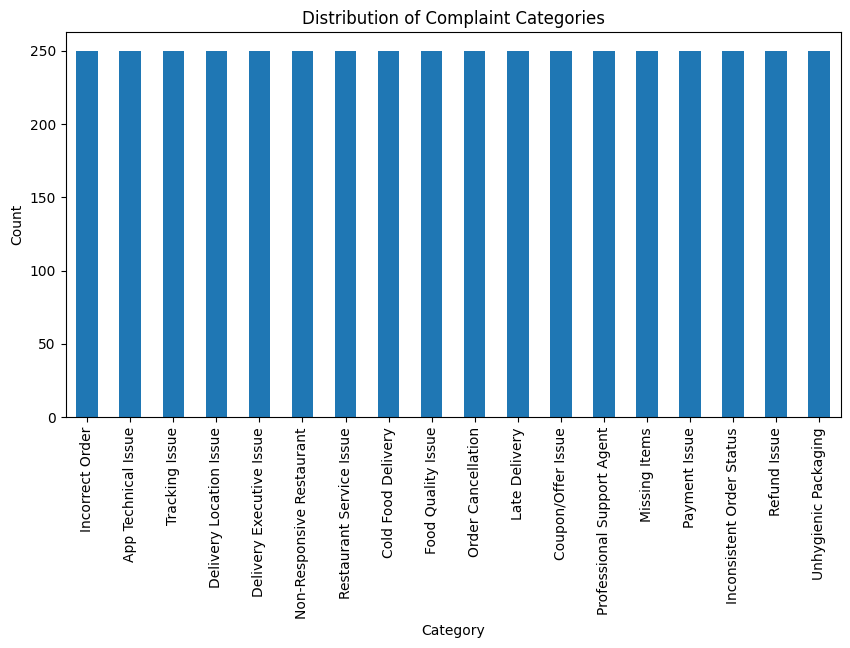

In [8]:
df['Category'].value_counts().plot(kind='bar', figsize=(10, 5))
plt.title('Distribution of Complaint Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.show()

In [9]:
# Feature Engineering

def count_len(text):
    return len(text)-text.count(" ")
df['Complaint Text length']=df['Complaint_Text'].apply(lambda x : count_len(x))
df.head()

,Complaint_ID,Complaint_Text,Category,Complaint Text length
0,SWG177101,Wrong food delivered. The order doesn't match ...,Incorrect Order,88
1,SWG245237,This has happened multiple times. App crashes ...,App Technical Issue,103
2,SWG437902,Delivery tracking shows wrong delivery executi...,Tracking Issue,62
3,SWG970049,Please resolve this issue immediately. Deliver...,Delivery Location Issue,113
4,SWG701969,This has happened multiple times. Delivery boy...,Delivery Executive Issue,89


### Text Cleaning 

In [10]:
## preprocessing

def data_pre_processing(text):
    text = "".join([char for char in text if char not in punctuation]) ## Remove punctuation
    text = re.split(" ",text.lower())                                   ## Tokenize
    text = [word for word in text if word not in stopwords.words('english')] ## Remove Stopwords
    text = [WordNetLemmatizer().lemmatize(word) for word in text]           ## Lemmatize the words
    return text

In [11]:
%%time
df['cleaned_complaint']=df['Complaint_Text'].apply(lambda x : data_pre_processing(x))
df[['Complaint_Text', 'cleaned_complaint']].head()

CPU times: total: 15.8 s
Wall time: 15.8 s


,Complaint_Text,cleaned_complaint
0,Wrong food delivered. The order doesn't match ...,"[wrong, food, delivered, order, doesnt, match,..."
1,This has happened multiple times. App crashes ...,"[happened, multiple, time, app, crash, trying,..."
2,Delivery tracking shows wrong delivery executi...,"[delivery, tracking, show, wrong, delivery, ex..."
3,Please resolve this issue immediately. Deliver...,"[please, resolve, issue, immediately, delivery..."
4,This has happened multiple times. Delivery boy...,"[happened, multiple, time, delivery, boy, didn..."


## ✅  Word Embeddings (GloVe)

In [12]:
from tqdm import tqdm

# Load GloVe
embeddings_index = {}
with open('glove.6B.100d.txt', encoding='utf8') as f:
    for line in tqdm(f):
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs

# Convert sentences to vectors (average of word embeddings)
def get_vector(text):
    # If text is a list (from preprocessing), join to string
    if isinstance(text, list):
        words = text
    else:
        words = str(text).split()
    valid_words = [embeddings_index[word] for word in words if word in embeddings_index]
    if valid_words:
        return np.mean(valid_words, axis=0)
    else:
        return np.zeros(100)

X_vectors = np.vstack(df['cleaned_complaint'].apply(get_vector))

400000it [00:10, 37588.33it/s]


In [13]:
X_vectors

array([[-0.22838917,  0.2154152 ,  0.3818487 , ...,  0.0417259 ,
        -0.0474938 ,  0.28921077],
       [-0.12514392,  0.01916716,  0.31316626, ..., -0.04264285,
         0.13836274,  0.047564  ],
       [ 0.07849625, -0.11221699,  0.22532338, ..., -0.1777825 ,
         0.20245375,  0.25553748],
       ...,
       [-0.15494621, -0.16214949,  0.3088657 , ..., -0.16109972,
         0.29168314, -0.01569321],
       [ 0.087517  , -0.13910322,  0.22592865, ..., -0.04828378,
         0.27796096,  0.1452664 ],
       [-0.1252505 ,  0.02010383, -0.03510799, ..., -0.02568583,
         0.41247347,  0.36072335]], shape=(4500, 100), dtype=float32)

## Model building 

In [14]:
# label encoding

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(df['Category'])

In [15]:
# Train-Test Split:

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_vectors, y, test_size=0.2, random_state=42)

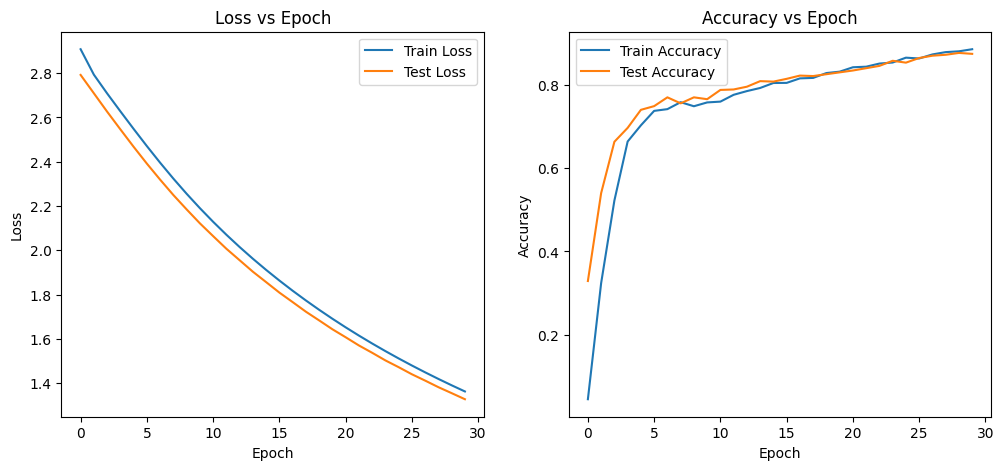

In [29]:
# Feedforward NN (PyTorch):

import torch
import torch.nn as nn
import torch.optim as optim

class FeedForwardNN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(FeedForwardNN, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.tanh = nn.Tanh()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.tanh(x)
        return self.fc2(x)

# Model setup
input_dim =100
hidden_dim = 64
output_dim = len(set(y))
model = FeedForwardNN(input_dim, hidden_dim, output_dim)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adagrad(model.parameters(),lr_decay=0.0001)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

# Track loss and accuracy
train_losses = []
test_losses = []
train_accuracies = []
test_accuracies = []

num_epochs = 30
for epoch in range(num_epochs):
    # Training
    model.train()
    outputs = model(X_train_tensor)
    loss = criterion(outputs, y_train_tensor)
    train_losses.append(loss.item())
    preds_train = outputs.argmax(dim=1)
    acc_train = (preds_train == y_train_tensor).float().mean().item()
    train_accuracies.append(acc_train)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Testing
    model.eval()
    with torch.no_grad():
        outputs_test = model(X_test_tensor)
        loss_test = criterion(outputs_test, torch.tensor(y_test, dtype=torch.long))
        test_losses.append(loss_test.item())
        preds_test = outputs_test.argmax(dim=1)
        acc_test = (preds_test == torch.tensor(y_test, dtype=torch.long)).float().mean().item()
        test_accuracies.append(acc_test)

# Plotting
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(1,2,2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Epoch')
plt.legend()
plt.show()


## Model Evaluation 

                            precision    recall  f1-score   support

       App Technical Issue       0.86      0.95      0.90        38
        Cold Food Delivery       0.91      0.98      0.95        53
        Coupon/Offer Issue       0.86      0.86      0.86        49
  Delivery Executive Issue       0.88      0.88      0.88        57
   Delivery Location Issue       0.81      0.84      0.82        50
        Food Quality Issue       0.98      1.00      0.99        47
 Inconsistent Order Status       0.90      0.80      0.85        45
           Incorrect Order       0.92      0.98      0.95        46
             Late Delivery       0.80      0.78      0.79        55
             Missing Items       1.00      0.91      0.95        58
 Non-Responsive Restaurant       1.00      0.84      0.91        51
        Order Cancellation       0.78      0.85      0.81        46
             Payment Issue       0.73      0.88      0.80        42
Professional Support Agent       0.74      0.90

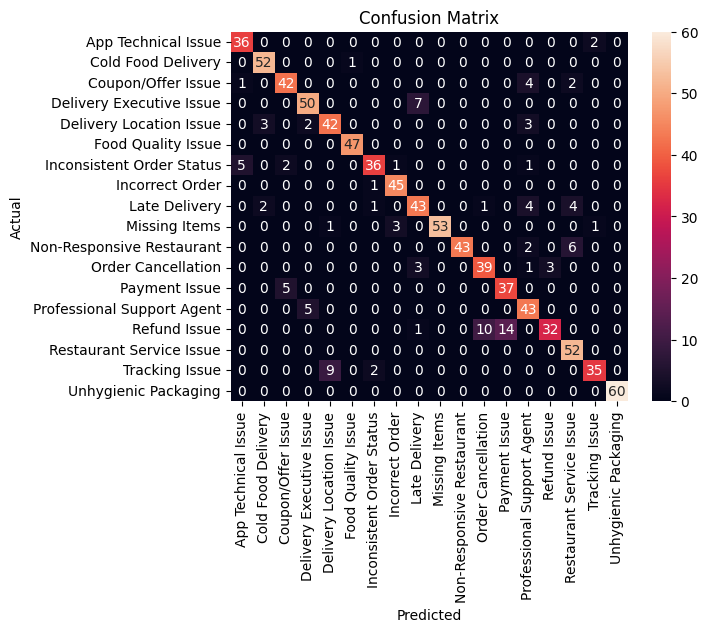

In [30]:
from sklearn.metrics import classification_report, confusion_matrix

# Evaluation
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
with torch.no_grad():
    preds = model(X_test_tensor).argmax(dim=1).numpy()

print(classification_report(y_test, preds, target_names=le.classes_))

# Confusion matrix
cm = confusion_matrix(y_test, preds)
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [31]:
misclassified_idx = np.where(preds != y_test)[0]
for i in misclassified_idx[:5]:
    print("True:", le.classes_[y_test[i]], "| Pred:", le.classes_[preds[i]])
    print("Text:\n",df.iloc[X_test[i]]['Complaint_Text'])
    print("---")

True: Professional Support Agent | Pred: Delivery Executive Issue
Text:
 0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
                           ...                        
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
Name: Complaint_Text, Length: 100, dtype: object
---
True: Refund Issue | Pred: Order Cancellation
Text:
 0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match ...
0    Wrong food delivered. The order doesn't match 

## SAVING MODEL AND LABEL ENCODER 
* joblib is a Python library used for saving and loading Python objects efficiently, especially large numpy arrays or scikit-learn models. In your notebook, joblib.dump(le, 'label_encoder.pkl') saves the fitted label encoder to a file, and you can later reload it with joblib.load('label_encoder.pkl').
* torch.save is a PyTorch function for saving tensors or model state dictionaries to disk. In your code, torch.save(model.state_dict(), 'feedforward_nn_model.pth') saves the trained neural network's parameters (weights and biases) to a file.


In [32]:
# Save model
torch.save(model.state_dict(), 'feedforward_nn_model.pth')

# Save label encoder
import joblib
joblib.dump(le, 'label_encoder.pkl')


['label_encoder.pkl']

## LOADING THE MODEL 
* When loading a PyTorch model with model.load_state_dict(torch.load('feedforward_nn_model.pth')), you must first create the model architecture in code because:

* The .pth file only contains the model's learned parameters (weights and biases), not the model's structure (layers, activation functions, etc.).


In [35]:
# Recreate the model architecture",
model_loaded = FeedForwardNN(input_dim, hidden_dim, output_dim)
model_loaded.load_state_dict(torch.load('feedforward_nn_model.pth'))
model_loaded.eval()
print('✅ Model loaded successfully!')

✅ Model loaded successfully!


In [42]:
# load label encoder
le_loaded=joblib.load('label_encoder.pkl')
print(f'✅ loaded successfully \n{le_loaded.classes_}')

✅ loaded successfully 
['App Technical Issue' 'Cold Food Delivery' 'Coupon/Offer Issue'
 'Delivery Executive Issue' 'Delivery Location Issue' 'Food Quality Issue'
 'Inconsistent Order Status' 'Incorrect Order' 'Late Delivery'
 'Missing Items' 'Non-Responsive Restaurant' 'Order Cancellation'
 'Payment Issue' 'Professional Support Agent' 'Refund Issue'
 'Restaurant Service Issue' 'Tracking Issue' 'Unhygienic Packaging']
